In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from random import randint
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import lightning as L
from torch.optim import Adam
import os
import pandas as pd

In [55]:
class simple_lstm(nn.Module):
    def __init__(self, in_features, hidden_size, layer_size, out_features):
        super(simple_lstm, self).__init__()
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.lstm = nn.LSTM(in_features, hidden_size, layer_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_features)
    def forward(self, x, h0=None, c0=None):
      if h0 is None or c0 is None:
          h0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).to(x.device)
          c0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).to(x.device)
      out, (hn, cn) = self.lstm(x, (h0, c0))
      out = self.fc(out[:, -1, :])
      return out, hn, cn

Реализуем датасет вручную

In [58]:
np.random.seed(0)
torch.manual_seed(0)
t = np.linspace(0, 100, 1000)
data = np.sin(t)

def sinteticdataset(data, seq_len):
    x_t = []
    y_t = []
    for i in range(len(data) - seq_len):
        x = data[i:(i+seq_len)]
        y = data[i+seq_len]
        x_t.append(x)
        y_t.append(y)
    return np.array(x_t), np.array(y_t)

seq_len = 10
X, y = sinteticdataset(data, seq_len)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

In [60]:
model = simple_lstm(in_features=1, hidden_size=100, layer_size=1, out_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [62]:
num_epochs = 100
h0 = None
c0 = None
for i in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs, h0, c0 = model(trainX, h0, c0)
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    h0 = h0.detach()
    c0 = c0.detach()

    if (i+1) % 10 == 0:
        print(f'Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.2866
Epoch [20/100], Loss: 0.0900
Epoch [30/100], Loss: 0.0379
Epoch [40/100], Loss: 0.0184
Epoch [50/100], Loss: 0.0027
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


Реализую lstm руками и сравню скорость обучения

In [65]:
class lstm_byhand(L.LightningModule):
    def __init__(self, in_features, hidden_size, layer_size, out_features):
        super().__init__()
        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)
        self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.fc = nn.Linear(hidden_size, out_features)

    def lstm_block(self, input_value, long_memory, short_memory):
        long_percent_remember = torch.sigmoid((input_value * self.wlr2)
                                               + (short_memory * self.wlr1)
                                               + self.blr1)
        pot_percent_remember = torch.sigmoid((input_value * self.wpr2) +
                                             (short_memory * self.wpr1) +
                                             self.bpr1)
        pot_long_memory = torch.tanh((input_value * self.wp2) +
                                             (short_memory * self.wp1) +
                                             self.bp1)

        new_ltm = (pot_long_memory * pot_percent_remember) + (long_percent_remember * long_memory)

        pot_percent_memory_remember = torch.sigmoid((input_value * self.wo2) +
                                             (short_memory * self.wo1) +
                                             self.bo1)

        new_short_memory = torch.tanh(new_ltm) * pot_percent_memory_remember

        return ([new_ltm, new_short_memory])

    def forward(self, x, h0=None, c0=None):
      if h0 is None or c0 is None:
          h0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).to(x.device)
          c0 = torch.zeros(self.layer_size, x.size(0), self.hidden_size).to(x.device)
      out, (hn, cn) = self.lstm_block(x, (h0, c0))
      out = self.fc(out[:, -1, :])
      return out, hn, cn

In [67]:
model_by_hand = lstm_byhand(in_features=1, hidden_size=100, layer_size=1, out_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [69]:
num_epochs = 100
h0 = None
c0 = None
for i in range(num_epochs):
    model_by_hand.train()
    optimizer.zero_grad()
    outputs, h0, c0 = model(trainX, h0, c0)
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    h0 = h0.detach()
    c0 = c0.detach()

    if (i+1) % 10 == 0:
        print(f'Epoch [{i+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0312
Epoch [20/100], Loss: 0.0132
Epoch [30/100], Loss: 0.0036
Epoch [40/100], Loss: 0.0004
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0000
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000


Забавно, но реализованный руками блок, быстрее зануляет лосс

Реализую другую модельку, предсказывающую значение пятого дня

In [8]:
class lstm_byhand(L.LightningModule):
    def __init__(self):
        super().__init__()
        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)
        self.wlr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wlr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.blr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wpr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wpr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bpr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wp1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wp2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bp1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

        self.wo1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.wo2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bo1 = nn.Parameter(torch.tensor(0.), requires_grad=True)

    def lstm_block(self, input_value, long_memory, short_memory):
        long_percent_remember = torch.sigmoid((input_value * self.wlr2)
                                               + (short_memory * self.wlr1)
                                               + self.blr1)
        pot_percent_remember = torch.sigmoid((input_value * self.wpr2) +
                                             (short_memory * self.wpr1) +
                                             self.bpr1)
        pot_long_memory = torch.tanh((input_value * self.wp2) +
                                             (short_memory * self.wp1) +
                                             self.bp1)

        new_ltm = (pot_long_memory * pot_percent_remember) + (long_percent_remember * long_memory)

        pot_percent_memory_remember = torch.sigmoid((input_value * self.wo2) +
                                             (short_memory * self.wo1) +
                                             self.bo1)

        new_short_memory = torch.tanh(new_ltm) * pot_percent_memory_remember

        return ([new_ltm, new_short_memory])

    def forward(self, input):
        long_memory = 0
        short_memory = 0
        day1 = input[0]
        day2 = input[1]
        day3 = input[2]
        day4 = input[3]
        long_memory, short_memory = self.lstm_block(day1, long_memory, short_memory)
        long_memory, short_memory = self.lstm_block(day2, long_memory, short_memory)
        long_memory, short_memory = self.lstm_block(day3, long_memory, short_memory)
        long_memory, short_memory = self.lstm_block(day4, long_memory, short_memory)
        return short_memory
        
    def configure_optimizers(self):
        return Adam(self.parameters())

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])
        loss = (output_i - label_i)**2 
        
        self.log('train_loss', loss)
        if (label_i==0):
            self.log('out_0', output_i)
        else:
            self.log('out_1', output_i)
        return loss

In [9]:
model2 = lstm_byhand()

In [10]:
print('company A, OBSERVED 0, predicted=', model2(torch.tensor([0., 0.5, 0.25, 1.])).detach())

print('company B, OBSERVED 1, predicted=', model2(torch.tensor([1., 0.5, 0.25, 1.])).detach())

company A, OBSERVED 0, predicted= tensor(-0.0839)
company B, OBSERVED 1, predicted= tensor(-0.0886)


In [11]:
inputs = torch.tensor([[0., 0.5, 0.25, 1.], [1., 0.5, 0.25, 1.]])
labels = torch.tensor([0., 1.])

In [12]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [13]:
trainer = L.Trainer(max_epochs=4000)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model2, train_dataloaders=dataloader)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 12     | n/a 
---------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
E:\anaconda\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
E:\anaconda\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=4000` reached.


In [15]:
print('company A, OBSERVED 0, predicted=', model2(torch.tensor([0., 0.5, 0.25, 1.])).detach())

print('company B, OBSERVED 1, predicted=', model2(torch.tensor([1., 0.5, 0.25, 1.])).detach())

company A, OBSERVED 0, predicted= tensor(0.0020)
company B, OBSERVED 1, predicted= tensor(0.9298)


In [16]:
import glob
logs = glob.glob("**/events.out.tfevents.*", recursive=True)
print(logs)

['lightning_logs\\version_2\\events.out.tfevents.1755241282.WIN-QQUTALPEQMA.10556.0', 'lightning_logs\\version_3\\events.out.tfevents.1755242846.WIN-QQUTALPEQMA.13560.0']


In [19]:
path_to_best_checkpoint = trainer.checkpoint_callback.best_model_path

In [21]:
trainer = L.Trainer(max_epochs=5000)
trainer.fit(model2, train_dataloaders=dataloader, ckpt_path=path_to_best_checkpoint)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at C:\Users\user\lightning_logs\version_3\checkpoints\epoch=3999-step=8000.ckpt
E:\anaconda\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:395: The dirpath has changed from 'C:\\Users\\user\\lightning_logs\\version_3\\checkpoints' to 'C:\\Users\\user\\lightning_logs\\version_4\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 12     | n/a 
---------------------------------------

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5000` reached.


![](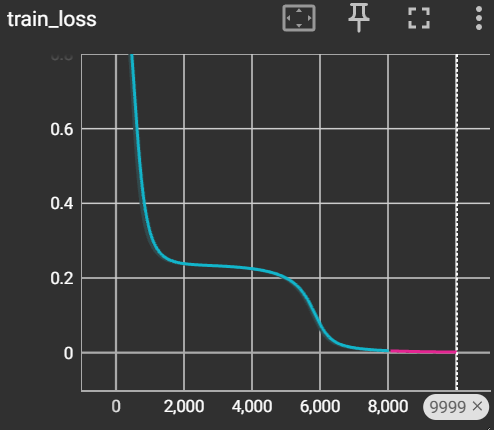)